## Selection DGP


In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import doubleml as dml
from lightgbm import LGBMRegressor, LGBMClassifier

### Base Data

Treated percentage: 11.85%
Percentage of observed outcomes: 43.95%
Treated percentage (observed): 26.96%
Percentage of Yg = 0 for treated: 62.28%
ATE: 0.131
ATT: 0.144
ATT cond. on Yg > 0: 0.353
ATT cond. on Yg = 0: 0.000


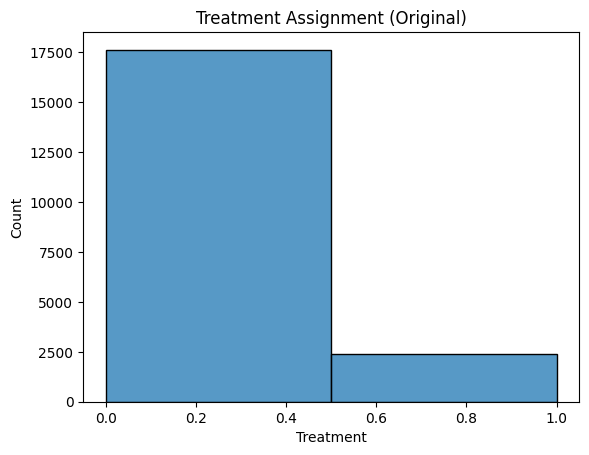

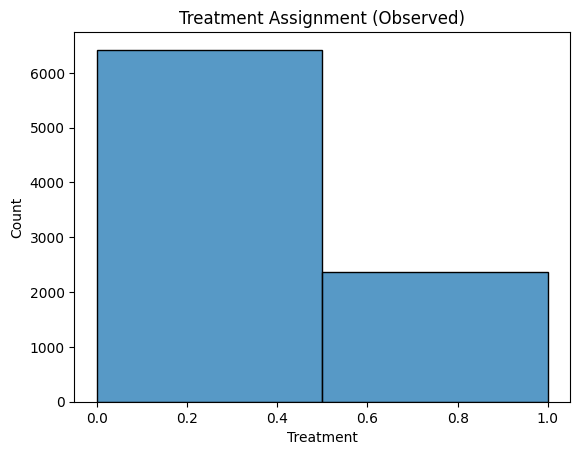

In [73]:
np.random.seed(42)
n = 10_000

# Step 1: Generate three covariates
X1 = np.random.normal(0, 1, 2*n)  # Covariate 1: Normally distributed
X2 = np.random.uniform(0, 1, 2*n)  # Covariate 2: Uniformly distributed
X3 = np.random.binomial(1, 0.3, 2*n)  # Covariate 3: Binary (Bernoulli trial)
X = np.column_stack([np.ones(2*n), X1, X2, X3])  # Design matrix

# Step 2: Define the treatment assignment probabilities (propensity scores)
# Use a logistic model with skewed coefficients to introduce imbalance
gamma = np.array([-2, 0.2, -0.1, 0.2])  # Coefficients for covariates (intercept, X1, X2, X3)
logits = X @ gamma  # Linear predictor
ps = 1 / (1 + np.exp(-logits))  # Logistic function

# Step 3: Assign treatment based on the propensity scores
D = np.random.binomial(1, ps)  # 1 if treated, 0 otherwise

# Step 4: Generate the outcome variable (count data)
# Calculate the Poisson rate (log-link function)
beta = np.array([-0.2, 0.5, -0.5, 0.2])  # Coefficients for covariates (intercept, X1, X2, X3)
log_lambda = X @ beta  # Linear predictor
lambda_ = np.exp(log_lambda)  # Rate parameter (Poisson mean)

# Generate count data from Poisson distribution
Yg0 = np.random.poisson(lambda_)
Yg1 = np.random.poisson(lambda_ + .5)  # Increase the rate by .5

# Ensure that Yg0 = 0 for unit with D = 0
Yg0 = np.where(Yg1 == 0, 0, Yg0)
Yg1 = np.where(Yg0 == 0, 0, Yg1)

Yg = D*Yg1 + (1-D)*Yg0 # SUTVA assumption

observed = (Yg > 0) | (D == 1)

# generate cancellations
C = np.random.poisson(0.2 * lambda_)
Y0 = np.maximum(Yg0 - C, 0)
Y1 = np.maximum(Yg1 - C, 0)
Y = D*Y1 + (1-D)*Y0 # SUTVA assumption

# Combine into a DataFrame
data = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'D': D,
    'Y': Y,
    'C': C,
    'Y0': Y0,
    'Y1': Y1,
    'observed': observed,
    'Yg>0': Yg > 0,
    'm_oracle': ps,
})

print(f"Treated percentage: {data['D'].mean() * 100:.2f}%")
print(f"Percentage of observed outcomes: {data['observed'].mean() * 100:.2f}%")
print(f"Treated percentage (observed): {data['D'].loc[data['observed']].mean() * 100:.2f}%")
print(f"Percentage of Yg = 0 for treated: {data.loc[data['D'] == 1, 'Y'].eq(0).mean() * 100:.2f}%")

print(f"ATE: {data['Y1'].mean() - data['Y0'].mean():.3f}")
print(f"ATT: {data.loc[data['D'] == 1, 'Y'].mean() - data.loc[data['D'] == 1, 'Y0'].mean():.3f}")
print(f"ATT cond. on Yg > 0: {data.loc[data['D'] == 1, 'Y'].loc[data['Yg>0']].mean() - data.loc[data['D'] == 1, 'Y0'].loc[data['Yg>0']].mean():.3f}")
print(f"ATT cond. on Yg = 0: {data.loc[data['D'] == 1, 'Y'].loc[~data['Yg>0']].mean() - data.loc[data['D'] == 1, 'Y0'].loc[~data['Yg>0']].mean():.3f}")

# Step 5: Visualize treatment imbalance
sns.histplot(data['D'], bins=2, kde=False)
plt.title("Treatment Assignment (Original)")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.show()

sns.histplot(data[data['observed']]['D'], bins=2, kde=False)
plt.title("Treatment Assignment (Observed)")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.show()


## Comparison observed vs unobserved

### Outcome Averages

In [74]:
print("All Data")
data.groupby(['D', 'Yg>0'])['Y'].mean()

All Data


D  Yg>0 
0  False    0.000000
   True     1.393864
1  False    0.000000
   True     1.829545
Name: Y, dtype: float64

In [75]:
print("Observed Data")
data[data['observed']].groupby(['D', 'Yg>0'])['Y'].mean()

Observed Data


D  Yg>0 
0  True     1.393864
1  False    0.000000
   True     1.829545
Name: Y, dtype: float64

### Effect Estimation

In [76]:
ml_g = LGBMRegressor(n_estimators=500, learning_rate=0.02, verbose=-1)
ml_m = LGBMClassifier(n_estimators=500, learning_rate=0.02, verbose=-1)

In [77]:
dml_dict = {
    "score": "ATTE",
    "ml_g": ml_g,
    "ml_m": ml_m,
    "trimming_threshold": 0.01,
}

#### Full Data

In [78]:
dml_data = dml.DoubleMLData(data, "Y", "D", x_cols=["X1", "X2", "X3"])
irm_model = dml.DoubleMLIRM(
    dml_data,
    **dml_dict,
)

In [79]:
irm_model.fit()
print(irm_model.nuisance_loss)
print(irm_model.summary)

{'ml_g0': array([[0.81663571]]), 'ml_g1': array([[1.18582446]]), 'ml_m': array([[0.36977243]])}
       coef   std err         t         P>|t|     2.5 %    97.5 %
D  0.172037  0.024582  6.998402  2.588984e-12  0.123856  0.220217


#### Observed Data

In [80]:
dml_data_observed = dml.DoubleMLData(data[data['observed']], "Y", "D", x_cols=["X1", "X2", "X3"])
irm_model_observed = dml.DoubleMLIRM(
    dml_data_observed,
    **dml_dict,
)

In [81]:
irm_model_observed.fit()
print(irm_model_observed.nuisance_loss)
print(irm_model_observed.summary)

{'ml_g0': array([[0.92277286]]), 'ml_g1': array([[1.17483633]]), 'ml_m': array([[0.59653124]])}
       coef   std err          t          P>|t|     2.5 %    97.5 %
D -0.603697  0.026658 -22.645769  1.535710e-113 -0.655947 -0.551448


#### Observed Data conditional on postive Outcome

In [82]:
dml_data_pos_outcome = dml.DoubleMLData(data[data['observed'] & data['Yg>0']], "Y", "D", x_cols=["X1", "X2", "X3"])
irm_model_pos_outcome = dml.DoubleMLIRM(
    dml_data_pos_outcome,
    **dml_dict,
)

In [83]:
irm_model_pos_outcome.fit()
print(irm_model_pos_outcome.nuisance_loss)
print(irm_model_pos_outcome.summary)

{'ml_g0': array([[0.92204163]]), 'ml_g1': array([[1.31573136]]), 'ml_m': array([[0.40750406]])}
       coef  std err         t         P>|t|     2.5 %    97.5 %
D  0.384439  0.04361  8.815299  1.193662e-18  0.298964  0.469913
